In [37]:
import pandas as pd
import h5py
import os
import numpy as np
from selenobot.utils import DATA_DIR, WEIGHTS_DIR
from selenobot.datasets import Dataset
# from scipy.stats import f_oneway, kstest
# import scipy
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from selenobot.classifiers import *

from tqdm import tqdm
from selenobot.files import MyProteinsFile
from sklearn.metrics import balanced_accuracy_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


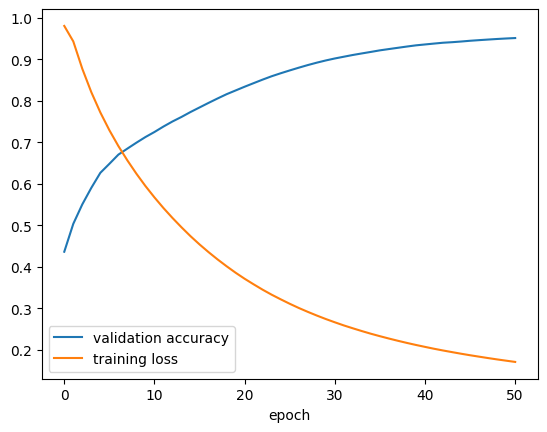

In [70]:
model = Classifier.load(os.path.join(WEIGHTS_DIR, 'model_epochs_50_lr_e8.pkl'))

fig, ax = plt.subplots()
ax.plot(np.arange(len(model.val_accs)), model.val_accs)
ax.plot(np.arange(len(model.train_losses)), model.train_losses)

ax.set_xlabel('epoch')

ax.legend(['validation accuracy', 'training loss'])
plt.show()

In [71]:
test_dataset = Dataset(pd.read_csv(os.path.join(DATA_DIR, 'test.csv')))
test_predictions = model.predict(test_dataset)

print('Test accuracy:', balanced_accuracy_score(test_dataset.labels, test_predictions))

Test accuracy: 0.9438451304541677


# Dataset exploration

In [15]:
sec_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sec.fa'))
sec_truncated_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sec.fa'))
sprot_fasta_file = MyProteinsFile(os.path.join(DATA_DIR, 'sprot.fa'))

print('Number of selenoproteins:', len(sec_fasta_file))
print('Number of selenoproteins (truncated):', len(sec_truncated_fasta_file))
print('Number of SwissProt sequences:', len(sprot_fasta_file))

Number of selenoproteins: 18988
Number of selenoproteins (truncated): 18988
Number of SwissProt sequences: 569539


In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), usecols=['gene_id'])
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), usecols=['gene_id'])
val_df = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'), usecols=['gene_id'])

print('Size of training data:', len(train_df))
print('Size of testing data:', len(test_df))
print('Size of validation data:', len(val_df))

Size of training data: 374775
Size of testing data: 119485
Size of validation data: 94000


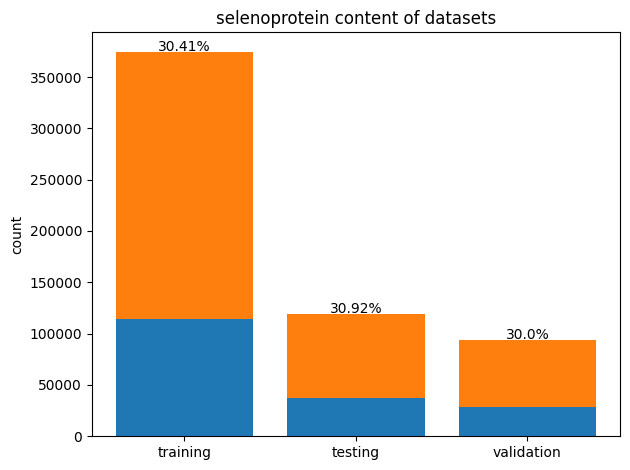

In [22]:
fig, ax = plt.subplots()

sec, non_sec = [], []
for i, df in enumerate([train_df, test_df, val_df]):
    n = np.sum(df.gene_id.str.contains(r'[1]'))
    sec.append(n)
    non_sec.append(len(df) - n)

    ax.text(i, len(df) + 1000, str(np.round(n / len(df) * 100, 2)) + '%', ha='center')

ax.bar(np.arange(3), sec)
ax.set_title('selenoprotein content of datasets')
ax.bar(np.arange(3), non_sec, bottom=sec)
ax.set_ylabel('count')
ax.set_xticks(np.arange(3), labels=['training', 'testing', 'validation'])

plt.tight_layout()

plt.show()


In [17]:
print(len(train_df) + len(val_df) + len(test_df))
print(len(sec_fasta_file) + len(sprot_fasta_file))

588260
588527


In [18]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), index_col=0)

In [19]:
X = train_df[[str(i) for i in range(1024)]].values
y = train_df.label.values

In [20]:
p_ref = 0.05 
p_vals = []
n = 50

for feature in tqdm(X.T):
    feature = np.random.choice(feature, n)
    mean, std = np.mean(feature), np.std(feature)
    # Null hypothesis is that the two distributions are identical, i.e. the data fit the normal distribution. 
    dist = lambda x : scipy.stats.norm.cdf(x, loc=mean, scale=std)
    p = kstest(feature, dist).pvalue
    p_vals.append(p)

print('Number of features which fit a normal distribution:', np.sum(np.array(p_vals) > p_ref))

# The lack of normality could be due to the fact that the sample size is big, as per https://datatab.net/tutorial/test-of-normality 
# Perhaps if I down-sample the data it would be better. 

  0%|          | 0/1024 [00:00<?, ?it/s]


NameError: name 'kstest' is not defined

In [ ]:
X = np.random.randint(10, size=(10, 10))

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
new_scaler = StandardScaler()
# new_scaler.var_ = scaler.var_
new_scaler.scale_ = scaler.scale_ 
new_scaler.mean_ = scaler.mean_

In [ ]:
X = new_scaler.transform(X)

AttributeError: 'StandardScaler' object has no attribute 'mean_'

In [ ]:
# kbest = SelectKBest(f_classif)
# kbest.fit(X, y)

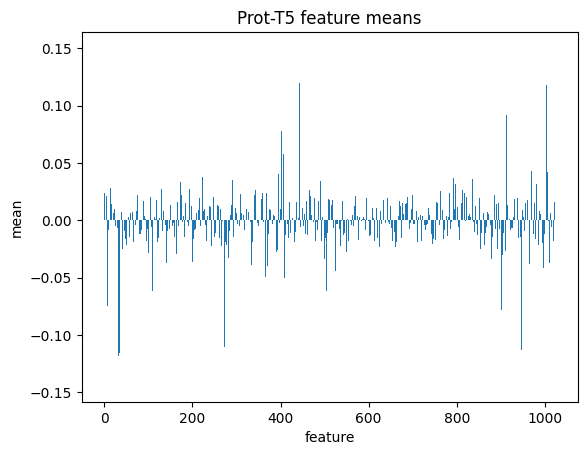

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Prot-T5 feature means')
ax.set_ylabel('mean')
ax.set_xlabel('feature')
ax.bar(np.arange(X.shape[1]), X.mean(axis=0))
plt.show()

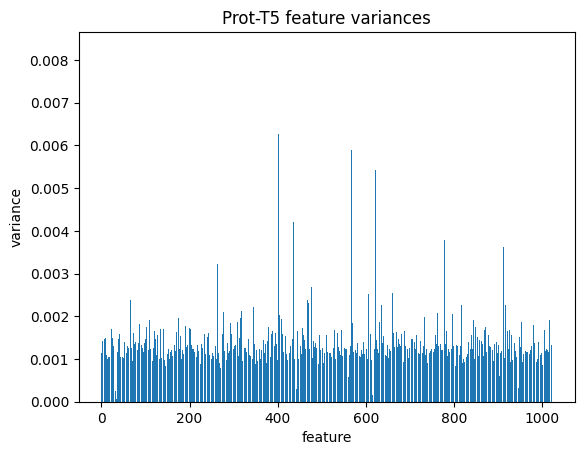

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Prot-T5 feature variances')
ax.set_ylabel('variance')
ax.set_xlabel('feature')
ax.bar(np.arange(X.shape[1]), X.var(axis=0))
plt.show()

In [ ]:
print('Path exists:', os.path.exists('/home/prichter/Downloads/RS_GCF_000238295.3_embedding.h5'))
# example_embedding_path = '/home/prichter/Downloads/RS_GCF_000238295.3_embedding.h5'
example_embedding_path = '/home/prichter/Downloads/GB_GCA_019232935.1_embedding.h5'

Path exists: True


In [ ]:
# What to Josh's GTDB embedding files look like?
store = pd.HDFStore(example_embedding_path, 'r')

In [ ]:
os.path.join(DATA_DIR, 'val.csv')

'/home/prichter/Documents/selenobot/selenobot/../data/val.csv'

In [ ]:
# df = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'), index_col=0)
# df = df.set_index('id')
# df.index.name = 'gene_id'
# print(df)
# df.to_csv(os.path.join(DATA_DIR, 'val.csv'))

In [ ]:
store.close()

In [ ]:
with h5py.File(example_embedding_path, 'r') as f:
    keys = list(f.keys())
    dataset = f[keys[0]]
    embedding = np.empty(data.shape)
    dataset.read_direct(embedding)

In [ ]:
for file in ['train', 'test', 'val']:
    df = pd.read_csv(os.path.join(DATA_DIR, f'{file}.csv'), index_col=0)
    print(f'Number of {file} entries:', len(df))

Number of train entries: 374775
Number of test entries: 119485
Number of val entries: 94000


In [ ]:
[key.split(' # ')[0].replace('_', '.', 1) for key in keys]

['JAFAMZ010000001.1_1',
 'JAFAMZ010000001.1_2',
 'JAFAMZ010000001.1_3',
 'JAFAMZ010000001.1_4',
 'JAFAMZ010000001.1_5',
 'JAFAMZ010000002.1_1',
 'JAFAMZ010000002.1_2',
 'JAFAMZ010000003.1_1',
 'JAFAMZ010000003.1_2',
 'JAFAMZ010000003.1_3',
 'JAFAMZ010000003.1_4',
 'JAFAMZ010000004.1_1',
 'JAFAMZ010000004.1_10',
 'JAFAMZ010000004.1_2',
 'JAFAMZ010000004.1_3',
 'JAFAMZ010000004.1_4',
 'JAFAMZ010000004.1_5',
 'JAFAMZ010000004.1_6',
 'JAFAMZ010000004.1_7',
 'JAFAMZ010000004.1_8',
 'JAFAMZ010000004.1_9',
 'JAFAMZ010000005.1_1',
 'JAFAMZ010000005.1_2',
 'JAFAMZ010000005.1_3',
 'JAFAMZ010000006.1_1',
 'JAFAMZ010000006.1_2',
 'JAFAMZ010000006.1_3',
 'JAFAMZ010000006.1_4',
 'JAFAMZ010000006.1_5',
 'JAFAMZ010000006.1_6',
 'JAFAMZ010000006.1_7',
 'JAFAMZ010000006.1_8',
 'JAFAMZ010000006.1_9',
 'JAFAMZ010000007.1_1',
 'JAFAMZ010000007.1_2',
 'JAFAMZ010000007.1_3',
 'JAFAMZ010000008.1_1',
 'JAFAMZ010000008.1_2',
 'JAFAMZ010000008.1_3',
 'JAFAMZ010000008.1_4',
 'JAFAMZ010000008.1_5',
 'JAFAMZ0100000